<a href="https://colab.research.google.com/github/XescLlabres/tfgFLM/blob/main/HUSE_per_pacient/RFtraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
data1 = pd.read_csv('df_gower.csv')

In [ ]:
data1.drop(['ID', 'CLAVE'], axis=1)

,RECIST,GENDER,AGE_AT_TACE,DAYS_CT_PRETACE,WEIGHT,HEIGHT,BMI,BMI_CATEGORY,HCV,Alcohol _abuse\n,...,Tumoral_Distribution,I,II,III,IVa,IVb,V,VI,VII,VIII
0,0.0,1.0,82.0,47.0,64.0,1.47,29.62,3.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,1.0,71.0,26.0,55.0,1.52,23.81,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,48.0,75.0,65.0,1.69,22.76,2.0,1.0,1.0,...,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0
3,1.0,0.0,77.0,110.0,68.0,1.59,26.90,3.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,54.0,28.0,65.0,1.70,22.49,2.0,1.0,0.0,...,2.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,1.0,1.0,83.0,194.0,75.0,1.60,29.30,3.0,1.0,0.0,...,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
127,1.0,0.0,67.0,578.0,94.0,1.74,31.05,4.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
128,1.0,0.0,67.0,52.0,65.0,1.74,21.47,2.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
129,1.0,0.0,74.0,269.0,83.0,1.65,30.49,4.0,0.0,1.0,...,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneOut
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score

data1.columns = data1.columns.str.strip()

y = data1.loc[:, "RECIST"].values

X = data1.loc[:,(data1.columns != "RECIST") & (data1.columns != "ID") & (data1.columns != "CLAVE")].values

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)


# Crear el nou model de classificació (Random Forest)
loo = LeaveOneOut()
model = RandomForestClassifier(
    n_estimators=200,  # Nombre d'arbres
    max_depth= None,
    min_samples_leaf=1,
    min_samples_split=2,
    random_state=42,
    class_weight= 'balanced'  # Manejar classes desequilibrades
)


all_bootstrap_probabilities = []
training_metrics = []
# Inicialitzam acumulador per a la matriu de confusió
confusion_matrix_accumulator = {"TP": 0, "FP": 0, "TN": 0, "FN": 0}

# Aplicar LOOCV amb Bootstrap
for train_index, test_index in loo.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    fold_metrics = []

    for _ in range(100):
        X_train_bootstrap, y_train_bootstrap = resample(X_train_smote, y_train_smote, replace=True)

        model.fit(X_train_bootstrap, y_train_bootstrap)

        # Predicció en el conjunt d'entrenament bootstrap
        y_train_pred = model.predict(X_train_bootstrap)

        # Calcular la matriu de confusió
        tn, fp, fn, tp = confusion_matrix(y_train_bootstrap, y_train_pred).ravel()
        confusion_matrix_accumulator["TP"] += tp
        confusion_matrix_accumulator["FP"] += fp
        confusion_matrix_accumulator["TN"] += tn
        confusion_matrix_accumulator["FN"] += fn

        fold_metrics.append({
            "accuracy": accuracy_score(y_train_bootstrap, y_train_pred),
            "auc": roc_auc_score(y_train_bootstrap, model.predict_proba(X_train_bootstrap)[:, 1]),
            "precision": precision_score(y_train_bootstrap, y_train_pred, zero_division=0),
            "recall": recall_score(y_train_bootstrap, y_train_pred, zero_division=0)
        })

    mean_metrics = pd.DataFrame(fold_metrics).mean().to_dict()
    training_metrics.append(mean_metrics)

total_bootstrap_iterations = loo.get_n_splits(X_scaled) * 10
average_confusion_matrix = {k: v / total_bootstrap_iterations for k, v in confusion_matrix_accumulator.items()}

df_metrics = pd.DataFrame(training_metrics)
df_confusion_matrix = pd.DataFrame([average_confusion_matrix])

df_metrics.to_csv("training_metrics.csv", index=False)
df_confusion_matrix.to_csv("average_confusion_matrix.csv", index=False)

print("Matriz de confusión promedio guardada en 'average_confusion_matrix.csv'")


Matriz de confusión promedio guardada en 'average_confusion_matrix.csv'


<Figure size 1200x600 with 0 Axes>

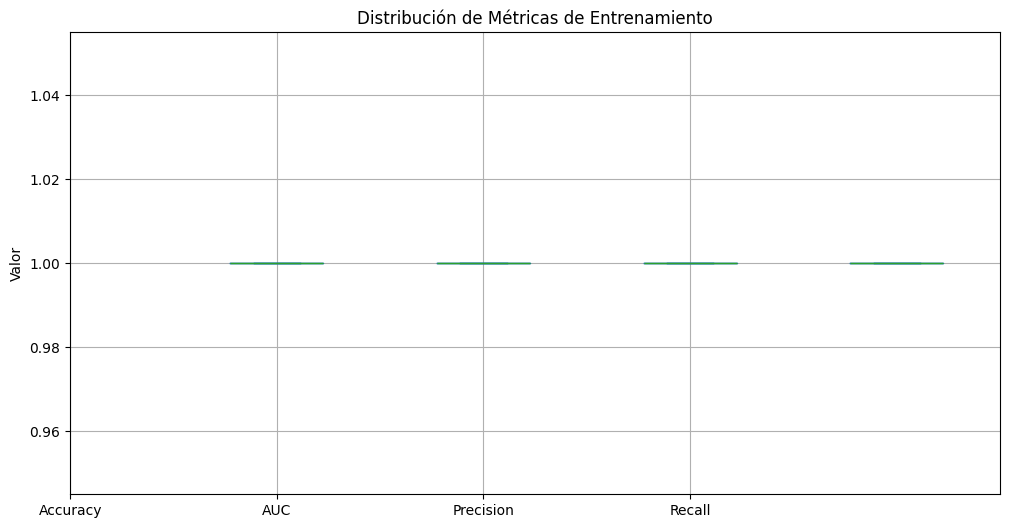

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_metrics = pd.read_csv("training_metrics.csv")

plt.figure(figsize=(12, 6))

# Boxplot per les mètriques de rendiment
df_metrics.plot(kind="box", figsize=(12, 6), grid=True)
plt.title("Distribución de Métricas de Entrenamiento")
plt.ylabel("Valor")
plt.xticks([0, 1, 2, 3], ['Accuracy', 'AUC', 'Precision', 'Recall'])

plt.show()


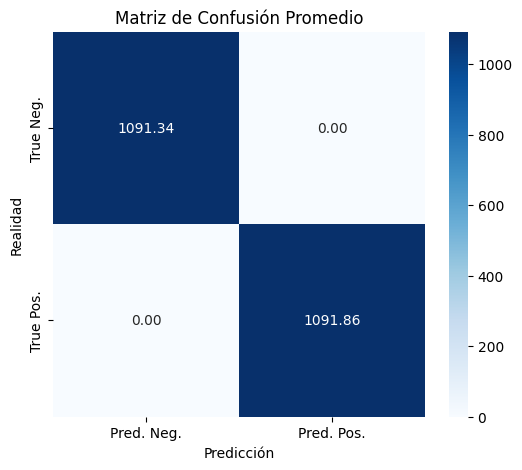

In [ ]:
# Cargar la matriz de confusión promedio
df_confusion_matrix = pd.read_csv("average_confusion_matrix.csv")

confusion_matrix_values = [
    [df_confusion_matrix["TN"][0], df_confusion_matrix["FP"][0]],
    [df_confusion_matrix["FN"][0], df_confusion_matrix["TP"][0]]
]

plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix_values, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=["Pred. Neg.", "Pred. Pos."],
            yticklabels=["True Neg.", "True Pos."])
plt.title("Matriz de Confusión Promedio")
plt.xlabel("Predicción")
plt.ylabel("Realidad")
plt.show()
